# Lab 4: Building an Image Classifier from Scratch


The main goal of this lab is to create an image classifier from scratch using the Keras package. You will create a binary classifier based on an object type of your choice. The classifier will accept images and then predict whether or not a given image contains that object. For example, if you chose your object to be a cat, then the classifier would accept images and predict 1 if it believes there is a cat in the image or a 0 if not. 

You will build and train a classifier in two ways: 
- first using the original data set that you create, and 
- second, using data augmentation techniques. 




## Part 1: Prep Work
### Choose an Object

Try to think of an object that is readily available for taking pictures and, preferably, outdoors, as that will add to the natural variability to the data.

### Create a Dataset

Take 80 pictures of the chosen object and 80 pictures of other things that are not your object. Each group member should supply a roughly equal number of pictures so as to increase variability in your dataset. 

From these 160 images you will create a training set (50 object/50 not object), a validation set (15 object/15 not object), and a test set (15 object/15 not object).

It's best if your dataset is diverse, so take pictures of the chosen **object** with, for example, different lighting, from different angles, different distances from camera, different examples of the same type of object. Similarly for the **not object** images: try to include a variety of objects in different ways. 

## Part 2: Using the Original Data

### Dataset Verification

You should verify that the training, validation, and test sets have the correct number of images (the `os` functions should help with this) and that the data is organized in `train`, `validation`, and `test` folders. 

### Dataset Loading and Processing with Image Data Generators

You should now create image data generators for your training, validation, and test datasets that will allow you to feed them into your model in batches. The images should be resized to 148x148 pixels and scaled so all pixel values are between 0 and 1. 

You should then use the training data generator to print out some examples of the training images and corresponding labels. 

### Create and Evaluate a Model

Build a convolutional neural network and use the validation loss and accuracy to select the best architecture and hyperparameters so that you can maximize the validation accuracy. 

Any overfitting should be addressed; that is, if your model begins overfitting after epoch 3, you should not quote validation accuracy after epoch 15. And, appropriate attempts should be made to reduce/eliminate the overfitting to improve overall model generalizability. 

### Report Accuracy on Test Set 

Your final step is to make predictions using the test set and report the final test set accuracy. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize, ImageDataGenerator
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import PIL
import PIL.Image
from tensorflow.keras.utils import to_categorical

In [ ]:
dataset_url = "/content/drive/MyDrive/Laptop_split"
data_dir = Path(dataset_url)

In [ ]:
laptop = []
train, train_label = [],[]
validation, validation_label = [],[]
test, test_label = [], []
for files in data_dir.iterdir():
  laptop.append(files.name.__str__())
  for split in files.iterdir():
    if split.name.__str__() == 'laptop':
      i = 1
    else:
      i = 0
    for images in split.iterdir():
      if files.name.__str__() == 'validation':
        validation.append(images.__str__())
        validation_label.append(i)
      elif files.name.__str__() == 'train':
        train.append(images.__str__())
        train_label.append(i)
      else:
        test.append(images.__str__())
        test_label.append(i)


*   Here we have used iterdir to load the data from the folder. 
  1.   First for loop runs for the laptop_split and gives name of the folder that is Train, Test and validation. 
  2.   Second for loop runs for each folder. For example it read the first folder validation folder check whats inside the folder and run for that folder. Which is laptop and no-laptop. 
  3.   Third For loop runs for each file present in the each subfolder laptop and no-laptop and gives the location of the each image.




### Load Images

In [ ]:
def load_data(location, labels):
  images = []
  for image_path in location:
    image  = load_img(image_path, color_mode='rgb', target_size = (148, 148))
    input_arr = np.array(image)
    input_arr = img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    images.append(input_arr)
  image_array = np.array(images)
  image_label = to_categorical(labels)
  return images, image_array, image_label

* Here, we created one method call load_data to get the images from the each location we get from the about three for loops.
* load_img is a function of the keras which load the images from the given location. We used color_mode as 'rgb' beacuse we are using RBG images and also further on we are going to develop the CNN so RGB is good for it. 
* We also specified the size of the image when we load the images so that way we have uniformed image size.
* Also with the help of np.array we converted image array to the numpy array so that we can get better control as well as imrpoved speed for array processing.
* to_categorical function takes the labels and create array with the # columns equal to the classes present in the data

In [ ]:
train_image, x_train, y_train = load_data(train,train_label)
test_image, x_test, y_test = load_data(test,test_label)
validation_image, x_val, y_val = load_data(validation, validation_label)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape,y_val.shape

((100, 1, 148, 148, 3),
 (100, 2),
 (30, 1, 148, 148, 3),
 (30, 2),
 (30, 1, 148, 148, 3),
 (30, 2))

### Scale the pixel value 0 to 1

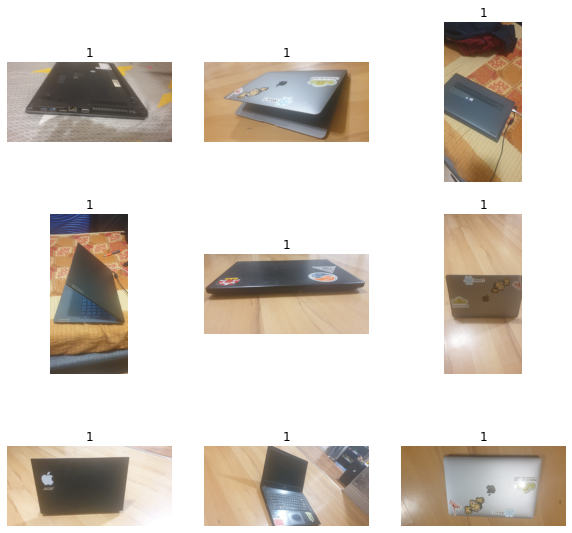

In [ ]:
import matplotlib.image as img
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  image = img.imread(train[i])
  plt.imshow(image)
  plt.title(train_label[i])
  plt.axis("off")

* with the help of matplotlib.image we load the first 9 images in the training data.

In [ ]:
x_train = x_train.astype('float32') / 255
x_train = x_train.reshape((100 , 148 , 148, 3))

x_test = x_test.astype('float32') / 255
x_test = x_test.reshape((30, 148 , 148, 3))

x_val = x_val.astype('float32') / 255
x_val = x_val.reshape((30, 148 , 148, 3))

* by dividing each images with 255 we scaled the images between 0 and 1. Which can improve computational power and reduce the time for model training as well.

### Create Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam, RMSprop

opt = Adam(
    learning_rate=0.001
)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(148,148,3), padding= 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# model.add(BatchNormalization(momentum=0.8))


model.add(Flatten())

# model.add(Dense(units= 512 , activation='relu'))
model.add(Dense(units= 254 , activation='relu'))
model.add(Dense(2, activation='softmax'))


# Compile the network 
model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
model.summary()

# Train the network
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=64, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [ ]:
# Test the network
test_loss, test_acc = model.evaluate(x_test, y_test)
print('test_acc:', test_acc)

1/1 [==============================] - 0s 478ms/step - loss: 0.5027 - accuracy: 0.8000
test_acc: 0.800000011920929


## Part 3: Using Data Augmentation

### Dataset Verification

You should verify that the training, validation, and test sets have the correct number of images (the `os` functions should help with this) and that the data is organized in a folder structure that will work with your image data generators. 

### Dataset Loading and Processing with Create Image Data Generators

You should now create image data generators for your training, validation, and test datasets that will allow you to feed them into your model in batches. The images should be resized to 148x148 pixels and scaled so all pixel values are between 0 and 1. 

### Add Data Augmentation 

You should now add data augmentation to your training data generator. All available types of augmentation should be used. 

Print an image and examples of the same image augmented in different ways. (The `.load_img()` and [`.flow()` method](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow) may be helpful here.)

### Create and Evaluate a Baseline Model

Use the best model from **Part 2** to train with the augmented data and evaluate on the validation data to get a baseline accuracy for the new model trained on the augmented dataset. 

### Tune the Model

With a more complex training set, you may be able to improve the accuracy through adjustments to the baseline model architecture and tuning the hyperparameters. 

### Report Accuracy on Test Set 

Your final step is to make predictions using the test set and report the final test set accuracy. 

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 0.2,
        brightness_range = (0, 0.9),
        channel_shift_range = 0.2,
        fill_mode = 'nearest',
        # vertical_flip = True, We have used laptop so it doesnt make any sense of fliping image virtically
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=True,
         )

test_datagen = ImageDataGenerator(
    rescale = 1. / 255,
)

validation_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
)

* With the help of the ImageDataGenerator we created the batch of the images.
1. Train_datagen will created augmented images.
2. test_datagen will created augmented images but it does only scaling.

In [ ]:
train_generator = train_datagen.flow_from_directory( 
        '/content/drive/MyDrive/Laptop_split/train',
        target_size=(148, 148),
        batch_size=10,
        # class_mode = 'categorical',
        classes = ['laptop', 'non_laptop'],
        seed= 42
        )


Found 100 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Laptop_split/test',
        target_size=(148, 148),
        batch_size=3,
        class_mode = 'categorical',
        seed=42
        )


Found 30 images belonging to 2 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/Laptop_split/validation',
        target_size=(148, 148),
        batch_size=3,
        class_mode = 'categorical',
        seed=42
        )

Found 30 images belonging to 2 classes.


flow_from_directory load the data from the given library with the 10 images for each batch and with the help of the target_size we can give size of the images. 

In [ ]:
imgs, labels = next(train_generator)
imgs.shape

(10, 148, 148, 3)

next() will load the next batch that is 10 images and with labels from the train_generator.

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


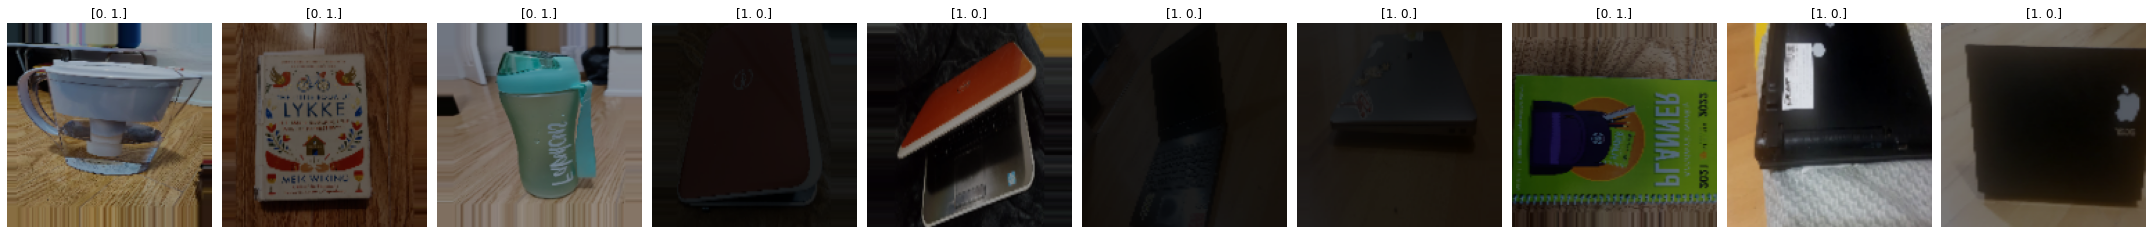

In [ ]:
fig,axes =  plt.subplots(1,10, figsize = (30,30))
axes = axes.flatten()
for img, ax, i  in zip(imgs, axes, labels):
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(i)
plt.tight_layout()
plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 74, 74, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 128)      

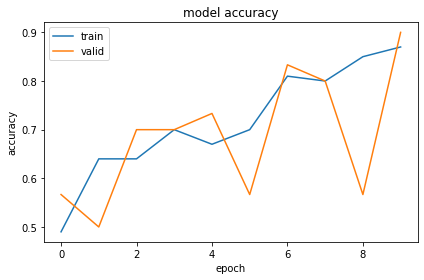

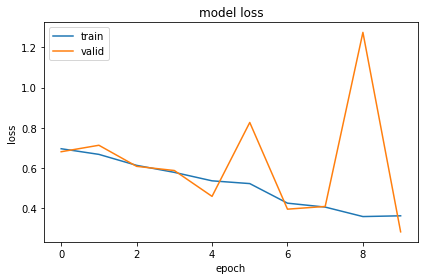

In [ ]:
opt = Adam(
    learning_rate=0.0001
)

model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(148,148,3), padding= 'same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters=256, kernel_size=(3,3), padding= 'same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(BatchNormalization(momentum=0.8))

model2.add(Flatten())

model2.add(Dense(units= 512 , activation='relu'))
# model2.add(Dropout((0.5) ))
model2.add(Dense(units= 254 , activation='relu'))
# model2.add(Dropout((0.5) ))
model2.add(Dense(2, activation='softmax'))

# Compile the network 
model2.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
model2.summary()

# Train the network
history2 = model2.fit( train_generator,
        steps_per_epoch= train_generator.n//train_generator.batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps = validation_generator.n//validation_generator.batch_size,
        batch_size=64, verbose=1
        )

# Plot the graph for accuracy and loss 
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.tight_layout( )
plt.show()

* Here, as a argument for the model2.fit() we gives train_datagenerator and validation_datagenerator to load the train and validation data. 

In [ ]:
# Test the network
test_loss, test_acc = model2.evaluate(test_generator)
print('test_acc:', test_acc)

10/10 [==============================] - 2s 186ms/step - loss: 0.4977 - accuracy: 0.8000
test_acc: 0.800000011920929


### References:

1. https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

2. https://www.youtube.com/watch?v=_L2uYfVV48I&t=257s&ab_channel=deeplizard

3. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

4. https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

5. https://www.tensorflow.org/tutorials/images/data_augmentation